Unigram Correlations
===

 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [27]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import scipy.sparse
import para
from itertools import groupby
from collections import Counter

In [28]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [29]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [30]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Load the predictions

In [6]:
# load the merged predictions dataframe
s = datetime.now()
audit_dir = os.path.join(derived_data_dir, 'audit')
merged_preds_df_filepath = os.path.join(audit_dir, 'merged_preds.pkl')
merged_preds_df = pd.read_pickle(merged_preds_df_filepath)
print(f"{datetime.now() - s}")
len(merged_preds_df)

0:00:02.388819


11735531

In [7]:
merged_preds_df.head()

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted_1week,is_reverted
0,867368228,0.304521,0.266850,0.125768,False,False
1,867140549,0.121477,0.051329,0.085052,False,False
2,862458099,0.008124,0.016422,0.069691,True,True
3,866634222,0.030305,0.020573,0.021695,False,False
4,862308858,0.184570,0.094484,0.243350,True,True


### Visualize

Just to sanity check what's in the data.

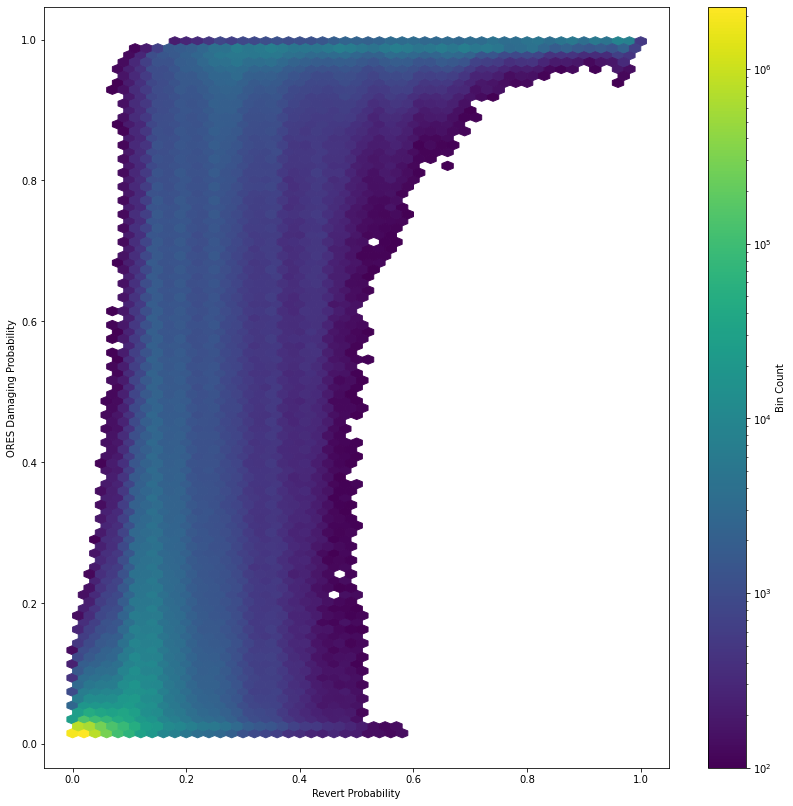

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
hb = plt.hexbin(merged_preds_df.revert_prob, merged_preds_df.damaging_prob_calibrated, bins='log', gridsize=(50,50), mincnt=100)
plt.xlabel('Revert Probability')
plt.ylabel('ORES Damaging Probability')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Bin Count')

plt.show()

### Load text data

In [9]:
text_vectors_dir = os.path.join(audit_dir, 'text_vectors')
fnames = sorted(os.listdir(text_vectors_dir), key=lambda fname: int(fname.split('.')[0].split('_')[-1]))
fnames[:3]

['td_doc_150000_coo_500000.npz',
 'td_doc_150000_coo_1000000.npz',
 'td_doc_150000_coo_1500000.npz']

In [10]:
td_mat = None
for fname in fnames[:4]:
    s = datetime.now()
    mat_block = scipy.sparse.load_npz(os.path.join(text_vectors_dir, fname))
    print(f"New component matrix loaded in {datetime.now() - s}.")
    if td_mat is None:
        td_mat = mat_block
    else:
        td_mat = scipy.sparse.vstack((td_mat, mat_block))
        print(f"Stacked new component matrix in {datetime.now() - s}. (curr shape: {td_mat.get_shape()})")

New component matrix loaded in 0:00:31.696451.
New component matrix loaded in 0:00:19.368880.
Stacked new component matrix in 0:00:46.929495. (curr shape: (1000000, 150000))
New component matrix loaded in 0:00:25.695831.
Stacked new component matrix in 0:01:07.044650. (curr shape: (1500000, 150000))
New component matrix loaded in 0:00:18.705438.
Stacked new component matrix in 0:01:10.544865. (curr shape: (2000000, 150000))


In [13]:
s = datetime.now()
td_mat = td_mat.tocsc()
print(f"{datetime.now() - s}")
td_mat

0:06:21.508247


<2000000x150000 sparse matrix of type '<class 'numpy.bool_'>'
	with 3287867946 stored elements in Compressed Sparse Column format>

In [34]:
s = datetime.now()
scipy.sparse.save_npz(os.path.join(audit_dir, 'td_mat_csc_2000000.npz'), td_mat)
print(f"{datetime.now() - s}")

0:28:48.705258


In [47]:
def get_doc_vocab(doc_counts_filepath, k=50000):
    with open(doc_counts_filepath, 'r') as infile:
        infile.readline()  # top line is just the total document count
        vocab_list = []
        for line in infile:
            if len(vocab_list) < k:
                token = line.strip().split(",")[0]
                if token == '':
                    token = ','
                vocab_list.append(token)
    assert len(vocab_list) == k
    vocab_dict = {token: i for i, token in enumerate(vocab_list)}
    return vocab_dict

token_counts_dir = os.path.join(audit_dir, 'token_counts')
content_doc_counts_filepath = os.path.join(token_counts_dir, 'all_content_doc_counts.csv')
removed_doc_counts_filepath = os.path.join(token_counts_dir, 'all_removed_doc_counts.csv')
inserted_doc_counts_filepath = os.path.join(token_counts_dir, 'all_inserted_doc_counts.csv')

content_vocab_dict = get_doc_vocab(content_doc_counts_filepath)
removed_vocab_dict = get_doc_vocab(removed_doc_counts_filepath)
inserted_vocab_dict = get_doc_vocab(inserted_doc_counts_filepath)

print("Constructed vocabs.")

Constructed vocabs.


In [11]:
rev_id_list = []
with open(os.path.join(audit_dir, 'rev_id_2020-08-01T05:40:00Z.txt'), 'r') as infile:
    for line in infile:
        if line.strip() != '':
            rev_id = int(line.strip())
            rev_id_list.append(rev_id)
len(rev_id_list)

9584147

In [18]:
rev_id_list = rev_id_list[:td_mat.shape[0]]
assert len(rev_id_list) == td_mat.shape[0]
len(rev_id_list)

2000000

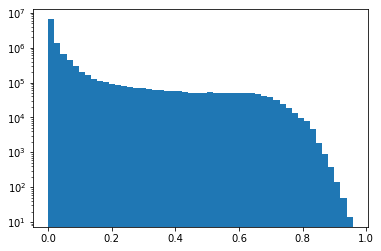

In [19]:
misalignment = np.abs(merged_preds_df.damaging_prob_calibrated - merged_preds_df.revert_prob)
plt.hist(misalignment, bins=50, log=True)
plt.show()

In [21]:
s = datetime.now()
merged_preds_subset = merged_preds_df[merged_preds_df.rev_id.isin(rev_id_list)]
print(f"{datetime.now() - s}")
len(merged_preds_subset)

0:00:09.050187


1999771

In [22]:
rev_id_misalignment_dict = {row.rev_id: row.damaging_prob_calibrated - row.revert_prob for row in merged_preds_subset.itertuples()}

In [24]:
misalignment = np.zeros(len(rev_id_list), dtype=float)
for i, rev_id in tqdm(enumerate(rev_id_list), total=len(rev_id_list)):
    if rev_id in rev_id_misalignment_dict:
        misalignment[i] = rev_id_misalignment_dict[rev_id]

100%|██████████| 2000000/2000000 [00:02<00:00, 686727.74it/s]


In [25]:
token_corr_list = []
for token in tqdm(content_vocab_dict.keys(), total=50000):
    ind = content_vocab_dict[token]
    unigram_arr = td_mat[:,ind]
    if np.sum(unigram_arr) == 0:
        continue
    unigram_arr = np.asarray(unigram_arr.todense()).reshape(-1)
    r, p = scipy.stats.pearsonr(misalignment, unigram_arr)
    token_corr_list.append((token, r))

100%|█████████▉| 49999/50000 [44:35<00:00, 18.69it/s] 


In [26]:
token_corr_list.sort(key=lambda tup: tup[1], reverse=True)

In [27]:
for token, corr in token_corr_list[:30]:
    print(f"{token:>20} {corr:.4f}")

             runtime 0.0394
      cinematography 0.0392
          Theatrical 0.0302
                mojo 0.0291
         distributor 0.0287
                 ''' 0.0284
                Plot 0.0283
            Tomatoes 0.0268
              Rotten 0.0252
            tomatoes 0.0248
           Fictional 0.0246
          screenplay 0.0228
         Screenplays 0.0227
            realizes 0.0225
     main_ingredient 0.0218
              rotten 0.0210
                Cast 0.0209
            starring 0.0204
            FILMPLOT 0.0197
               tcmdb 0.0196
           discovers 0.0196
          Wiktionary 0.0195
              learns 0.0192
         CinemaScore 0.0189
              poster 0.0189
                 Amg 0.0185
          aggregator 0.0185
https://www.census.gov/programs-surveys/popest/data/tables.2016.html 0.0182
<ref name="USCensusEst2016"> 0.0182
           wikiquote 0.0181


In [28]:
removed_token_corr_list = []
for token in tqdm(removed_vocab_dict.keys(), total=50000):
    ind = removed_vocab_dict[token] + 50000
    unigram_arr = td_mat[:,ind]
    if np.sum(unigram_arr) == 0:
        continue
    unigram_arr = np.asarray(unigram_arr.todense()).reshape(-1)
    r, p = scipy.stats.pearsonr(misalignment, unigram_arr)
    removed_token_corr_list.append((token, r))

100%|█████████▉| 49999/50000 [41:20<00:00, 20.16it/s]


In [29]:
removed_token_corr_list.sort(key=lambda tup: tup[1], reverse=True)

In [30]:
for token, corr in removed_token_corr_list[:30]:
    print(f"{token:>20} {corr:.4f}")

                pos2 0.0078
                 Rls 0.0065
            Faizabad 0.0053
              Arriva 0.0053
              Yahweh 0.0047
         Londonderry 0.0041
           Wikimapia 0.0038
    pseudoscientific 0.0032
               Desam 0.0031
        routesonline 0.0030
                 TOC 0.0030
                Zulu 0.0030
                Jeju 0.0028
            tocright 0.0027
               Mohun 0.0027
             notemid 0.0025
             Noodles 0.0025
           Allahabad 0.0025
               Devgn 0.0025
             Manisha 0.0024
          label_size 0.0024
              Multan 0.0024
              Mormon 0.0023
             Koirala 0.0023
                Uday 0.0023
                 UBM 0.0023
                pos3 0.0023
                Jatt 0.0022
             sublist 0.0022
          wiktionary 0.0022


In [31]:
inserted_token_corr_list = []
for token in tqdm(inserted_vocab_dict.keys(), total=50000):
    ind = inserted_vocab_dict[token] + 100000
    unigram_arr = td_mat[:,ind]
    if np.sum(unigram_arr) == 0:
        continue
    unigram_arr = np.asarray(unigram_arr.todense()).reshape(-1)
    r, p = scipy.stats.pearsonr(misalignment, unigram_arr)
    inserted_token_corr_list.append((token, r))

100%|█████████▉| 49999/50000 [41:10<00:00, 20.24it/s]


In [32]:
inserted_token_corr_list.sort(key=lambda tup: tup[1], reverse=True)

In [33]:
for token, corr in inserted_token_corr_list[:30]:
    print(f"{token:>20} {corr:.4f}")

       INSERTION_END 0.0279
     INSERTION_START 0.0279
                yeet 0.0222
                 poo 0.0202
                  hi 0.0190
            fortnite 0.0185
            Fortnite 0.0172
                Yeet 0.0152
                 boi 0.0152
                 oof 0.0141
               ligma 0.0140
               hello 0.0130
                jeff 0.0105
               Ligma 0.0105
                 bob 0.0104
             pornhub 0.0103
                YEET 0.0102
                 bum 0.0098
                  yo 0.0098
                porn 0.0088
               butts 0.0086
               trump 0.0084
                 Poo 0.0083
                 mum 0.0077
               poopy 0.0077
                 pee 0.0075
                mama 0.0074
               sucks 0.0073
                 !!! 0.0071
              hitler 0.0071


### Create array for term

In [23]:
def create_array(token_index, total=9584147):
    db = sqlite3.connect(
        '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/td_doc_indices.sqlite',
        detect_types=sqlite3.PARSE_DECLTYPES
    )
    try:
        token_indicator_arr = np.zeros(total, dtype=bool)
        
        cursor = db.execute('SELECT revision_index FROM inds WHERE token_index = ?', (token_index,))
        inds = cursor.fetchall()
        if len(inds) > 0:
            inds_arr = np.array([ind[0] for ind in inds])
            token_indicator_arr[inds_arr] = 1
        return token_indicator_arr
    finally:
        db.close()

In [32]:
token_indicator_arr = create_array(1)
np.sum(token_indicator_arr)

37

In [25]:
for i in tqdm(range(150000)):
    token_indicator_arr = create_array(i)

  0%|          | 43/150000 [04:39<270:47:55,  6.50s/it]


KeyboardInterrupt: 

In [33]:
merged_preds_df['raw_misalignment'] = merged_preds_df.damaging_prob_calibrated - merged_preds_df.revert_prob

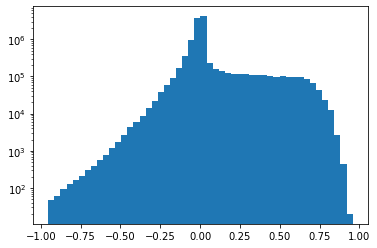

In [35]:
plt.hist(merged_preds_df.raw_misalignment, bins=50, log=True)
plt.show()

In [37]:
np.sum(merged_preds_df.raw_misalignment <= -0.5) / len(merged_preds_df)

0.0004551136203380997

In [46]:
for i in tqdm(range(50000,150000)):
    token_indicator_arr = create_array(i)
    token_count = np.sum(token_indicator_arr)
    r, p = 0, 0
    if token_count > 0:
        r, p = scipy.stats.pointbiserialr(token_indicator_arr, misalignment)
        print(token_count, r)
    if i > 50015:
        break

  0%|          | 1/100000 [00:05<151:40:23,  5.46s/it]

6734706 -0.011958062721951311


  0%|          | 2/100000 [00:10<150:28:02,  5.42s/it]

6734706 -0.011958062721951311


  0%|          | 4/100000 [00:12<111:31:10,  4.01s/it]

1757253 -0.06253406336676313


  0%|          | 6/100000 [00:13<83:19:40,  3.00s/it] 

1440860 -0.029219200839024385


  0%|          | 7/100000 [00:14<69:11:31,  2.49s/it]

1391497 -0.028220196567166452


  0%|          | 9/100000 [00:16<54:25:42,  1.96s/it]

1204816 -0.03557201865011078


  0%|          | 10/100000 [00:17<46:49:38,  1.69s/it]

1049757 -0.05718333908076264


  0%|          | 11/100000 [00:18<40:38:43,  1.46s/it]

982370 -0.05039008242871053


  0%|          | 12/100000 [00:19<35:55:45,  1.29s/it]

900572 -0.020720794745091337


  0%|          | 13/100000 [00:20<32:18:40,  1.16s/it]

849659 -0.03819003464500932


  0%|          | 14/100000 [00:20<29:41:10,  1.07s/it]

827829 -0.03889204531320107


  0%|          | 15/100000 [00:21<27:51:25,  1.00s/it]

825755 -0.025104077672833305


  0%|          | 16/100000 [00:22<26:07:55,  1.06it/s]

755064 -0.018316472001487696


  0%|          | 16/100000 [00:23<40:26:34,  1.46s/it]

716876 -0.03342303906253915


In [40]:
len(token_indicator_arr)

9584147

In [41]:
len(merged_preds_df.raw_misalignment)

11735531

In [42]:
rev_id_misalignment_dict = {row.rev_id: row.raw_misalignment for row in tqdm(merged_preds_df.itertuples(), total=len(merged_preds_df), desc='Building misalignment dict')}

100%|██████████| 11735531/11735531 [00:21<00:00, 545858.98it/s]


In [44]:
misalignment = np.zeros(len(rev_id_list), dtype=float)
for i, rev_id in tqdm(enumerate(rev_id_list), total=len(rev_id_list), desc='Building misalignment arr'):
    if rev_id in rev_id_misalignment_dict:
        misalignment[i] = rev_id_misalignment_dict[rev_id]

Building misalignment arr: 100%|██████████| 9584147/9584147 [00:10<00:00, 895338.73it/s] 


In [52]:
content_vocab_dict_fromIndex = {value: key for key, value in content_vocab_dict.items()}
removed_vocab_dict_fromIndex = {value: key for key, value in removed_vocab_dict.items()}
inserted_vocab_dict_fromIndex = {value: key for key, value in inserted_vocab_dict.items()}

In [56]:
corr_list = []
with open(os.path.join(audit_dir, 'doc_corr_2020-08-01T05:40:00Z.csv')) as infile:
    for line in infile:
        token_index, token_count, r, p = line.strip().split(",")
        token_index, token_count, r, p = int(token_index), int(token_count), float(r), float(p)
        if token_index < 50000:
            token = content_vocab_dict_fromIndex[token_index] if token_index in content_vocab_dict_fromIndex else ','
        elif token_index >= 50000 and token_index < 100000:
            token = removed_vocab_dict_fromIndex[token_index - 50000] if token_index - 50000 in removed_vocab_dict_fromIndex else ','
        elif token_index >= 100000 and token_index < 150000:
            token = inserted_vocab_dict_fromIndex[token_index - 100000] if token_index - 100000 in inserted_vocab_dict_fromIndex else ','
        else:
            raise ValueError(f"Token index ({token_index}) should be in [0,149999]")
        corr_list.append({
            'token_index': token_index, 
            'token': token,
            'token_count': token_count, 
            'r': r
        })
corr_df = pd.DataFrame(corr_list)
len(corr_df)

100000

In [57]:
corr_df.head()

,token_index,token,token_count,r
0,50000,REMOVAL_END,6734706,-0.011958
1,50001,REMOVAL_START,6734706,-0.011958
2,50002,WHITESPACE,0,0.000000
3,50003,|,1757253,-0.062534
4,50004,NEWLINE,0,0.000000


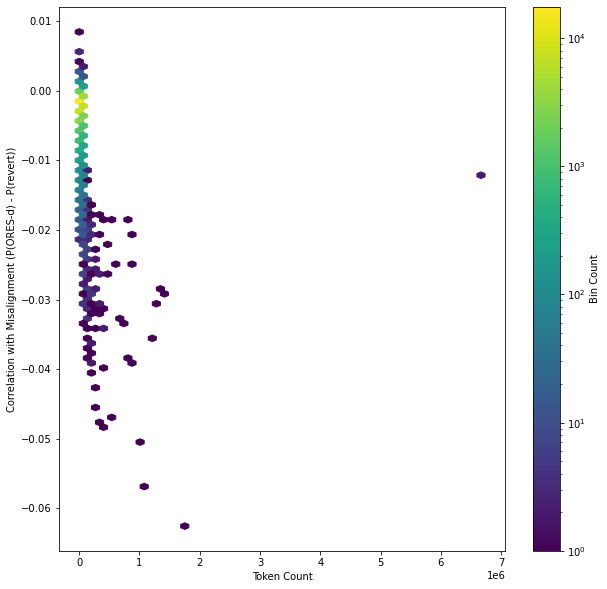

In [75]:
removed_corrs = corr_df[corr_df.token_index < 100000].sort_values(by='r')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hb = plt.hexbin(removed_corrs.token_count, removed_corrs.r, bins='log', gridsize=(50,50), mincnt=1)
plt.xlabel('Token Count')
plt.ylabel('Correlation with Misalignment (P(ORES-d) - P(revert))')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Bin Count')

plt.show()

In [74]:
removed_corrs.head(50)

,token_index,token,token_count,r
3,50003,|,1757253,-0.062534
9,50009,=,1049757,-0.057183
10,50010,-,982370,-0.050390
33,50033,2,338166,-0.048558
31,50031,1,339574,-0.047408
20,50020,:,594593,-0.047175
43,50043,3,269409,-0.045081
46,50046,4,230343,-0.042644
50,50050,5,216495,-0.040716
25,50025,2018,396658,-0.039782


In [73]:
removed_corrs.tail(50)

,token_index,token,token_count,r
6237,56237,Vijay,2409,0.001507
24309,74309,Sameer,430,0.001509
36568,86568,Vyas,237,0.001526
25150,75150,Rukh,410,0.001538
47190,97190,Roop,162,0.001589
46188,96188,Nidhi,167,0.001596
37089,87089,Sneha,232,0.001602
17660,67660,Pooja,684,0.001618
23220,73220,Anjali,461,0.001646
26535,76535,Mohanlal,379,0.001683


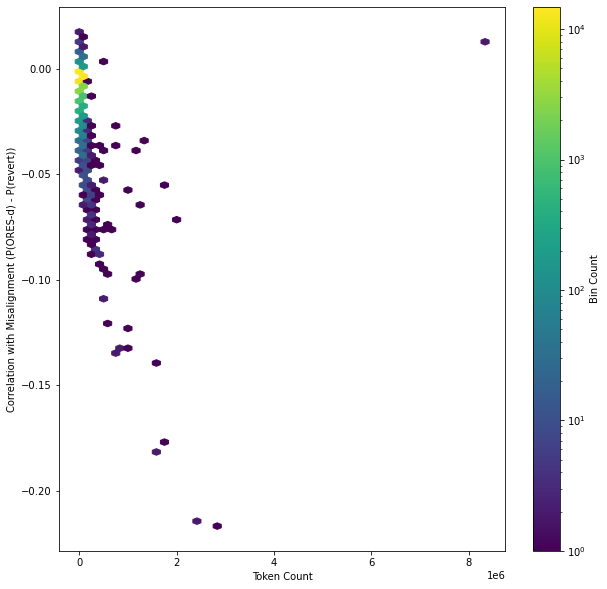

In [65]:
inserted_corrs = corr_df[corr_df.token_index >= 100000].sort_values(by='r')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hb = plt.hexbin(inserted_corrs.token_count, inserted_corrs.r, bins='log', gridsize=(50,50), mincnt=1)
plt.xlabel('Token Count')
plt.ylabel('Correlation with Misalignment (P(ORES-d) - P(revert))')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Bin Count')

plt.show()

In [72]:
inserted_corrs.head(50)

,token_index,token,token_count,r
50003,100003,|,2853586,-0.216673
50004,100004,]],2450296,-0.213512
50005,100005,[[,2402411,-0.213287
50011,100011,}},1591427,-0.182655
50012,100012,{{,1569681,-0.182537
50009,100009,=,1691056,-0.177022
50010,100010,-,1631385,-0.139654
50026,100026,title,745313,-0.135671
50027,100027,url,709121,-0.133900
50022,100022,</ref>,814991,-0.133275


In [71]:
inserted_corrs.tail(50)

,token_index,token,token_count,r
78978,128978,booty,446,0.005373
81697,131697,Poo,391,0.005385
72672,122672,mum,639,0.005408
83198,133198,lil,366,0.005413
88352,138352,butts,295,0.005418
58760,108760,amazing,2173,0.005482
94834,144834,hitler,233,0.005531
65918,115918,dumb,1049,0.005542
56944,106944,guy,2841,0.005590
91360,141360,pakistan,264,0.005663


In [70]:
inserted_corrs[inserted_corrs.token.str.startswith('Pray')]

,token_index,token,token_count,r
63480,113480,Prayer,1285,-0.006478
81127,131127,Pray,402,-0.003318
93304,143304,Prayers,246,-0.002972
73428,123428,Prayagraj,610,0.006023


In [76]:
def arcsin_transformation(p):
    return 2 * np.arcsin(np.sqrt(p))

def cohen_h(p1, p2):
    return arcsin_transformation(p1) - arcsin_transformation(p2)

In [78]:
cohen_h(0.6, 0.1)

1.1286531387919432

In [79]:
cohen_h(0.99, 0.9)

0.4431662664701652

In [83]:
cohen_h(0.59, 0.5)

0.18098645124654755

Predict: 
    
Features:
    - ORES - p(revert) > 0.9?
    - p(revert) - ORES > 0.9?
    
    - x1: max(h(ORES) - h(p(revert)), 0) ==> exp(beta) = 0.998
           1 unit increase in 0.998 * odds (conditional on x2 == 0)
    - x2: max(p(revert) - ORES, 0)
    

Outcome: 
y1: max(h(ORES) - h(p(revert)), 0)
    x1: word inserted? b1
    #x2?: word 2 inserted? b2
    #x2: word removed? b2
    #x3: word swapped?  b3
y2: max(p(revert) - ORES, 0)
    x2: word inserted?



In [88]:
fortnite_insertions = []
db = sqlite3.connect(
    '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/td_doc_indices.sqlite',
    detect_types=sqlite3.PARSE_DECLTYPES
)
try:
    cursor = db.execute('SELECT revision_index FROM inds WHERE token_index = ?', (111268,))
    inds = cursor.fetchall()
    if len(inds) > 0:
        for ind in [ind[0] for ind in inds]:
            fortnite_insertions.append(rev_id_list[ind])
finally:
    db.close()
len(fortnite_insertions)

1609

In [89]:
fortnite_insertions_df = merged_preds_df[merged_preds_df.rev_id.isin(fortnite_insertions)]
len(fortnite_insertions_df)

1609

In [90]:
fortnite_insertions_df.sample(n=20)

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted_1week,is_reverted,raw_misalignment
1627562,860488257,0.017862,0.018132,0.169568,False,False,-0.151437
7513852,868064565,0.302522,0.262805,0.517430,True,True,-0.254625
6016111,865223033,0.782449,0.979192,0.689643,True,True,0.289549
10033435,872963182,0.006856,0.016211,0.084347,False,False,-0.068136
7248326,867568109,0.673079,0.939811,0.278329,True,True,0.661481
286154,861123001,0.419648,0.544499,0.336512,True,True,0.207987
8866886,870641271,0.027205,0.019936,0.139488,True,True,-0.119551
3369386,860142104,0.875029,0.991706,0.272584,True,True,0.719122
10319998,873526782,0.010807,0.016876,0.027057,False,False,-0.010181
6244755,865660308,0.894536,0.993174,0.636143,True,True,0.357030


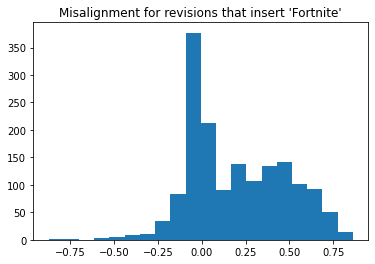

In [92]:

plt.hist(fortnite_insertions_df.raw_misalignment, bins=20)
plt.title("Misalignment for revisions that insert 'Fortnite'")
plt.show()

In [93]:
fortnite_insertions_df[fortnite_insertions_df.raw_misalignment>=0.5]

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted_1week,is_reverted,raw_misalignment
21196,858301367,0.771606,0.976844,0.375343,True,True,0.601502
43436,864464571,0.497620,0.725871,0.092794,True,True,0.633077
65919,867869926,0.840289,0.988274,0.253381,True,True,0.734893
71067,865200956,0.910896,0.994203,0.386532,True,True,0.607671
101867,861869319,0.815725,0.985031,0.456813,True,True,0.528218
...,...,...,...,...,...,...,...
11074712,875006792,0.900643,0.993578,0.449986,True,True,0.543591
11250647,875341478,0.629517,0.909571,0.229850,False,False,0.679721
11419335,875645472,0.665855,0.935552,0.397760,True,True,0.537792
11477967,875750292,0.900707,0.993582,0.372110,True,True,0.621472


In [96]:
np.sum((fortnite_insertions_df.revert_prob >= 0.5) == fortnite_insertions_df.is_reverted) / len(fortnite_insertions_df)

0.6768178993163455

0.03414149969935021


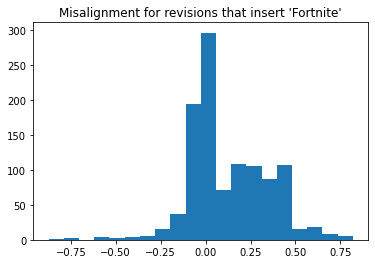

In [99]:
print(np.median(fortnite_insertions_df[(fortnite_insertions_df.revert_prob >= 0.5) == fortnite_insertions_df.is_reverted].raw_misalignment))

plt.hist(fortnite_insertions_df[(fortnite_insertions_df.revert_prob >= 0.5) == fortnite_insertions_df.is_reverted].raw_misalignment, bins=20)
plt.title("Misalignment for revisions that insert 'Fortnite'")
plt.show()

In [101]:
fortnite_insertions_df[(fortnite_insertions_df.revert_prob >= 0.5) == fortnite_insertions_df.is_reverted]

,rev_id,damaging_prob,damaging_prob_calibrated,revert_prob,is_reverted_1week,is_reverted,raw_misalignment
2562,862326039,0.765009,0.975291,0.739676,True,True,0.235615
6577,874495639,0.258366,0.183768,0.509025,True,True,-0.325257
12381,864414773,0.865132,0.990845,0.775611,True,True,0.215234
25778,862621571,0.794255,0.981483,0.940366,True,True,0.041117
57036,858948928,0.013891,0.017414,0.033178,False,False,-0.015764
...,...,...,...,...,...,...,...
11580504,875940642,0.294754,0.247460,0.811501,True,True,-0.564042
11581068,875941715,0.863907,0.990732,0.739471,True,True,0.251261
11581152,875941873,0.856375,0.990010,0.777822,True,True,0.212187
11583620,875946205,0.003320,0.015638,0.030560,False,False,-0.014922


In [102]:
prayagraj_insertions = []
db = sqlite3.connect(
    '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit/td_doc_indices.sqlite',
    detect_types=sqlite3.PARSE_DECLTYPES
)
try:
    cursor = db.execute('SELECT revision_index FROM inds WHERE token_index = ?', (123428,))
    inds = cursor.fetchall()
    if len(inds) > 0:
        for ind in [ind[0] for ind in inds]:
            prayagraj_insertions.append(rev_id_list[ind])
finally:
    db.close()
len(prayagraj_insertions)

610

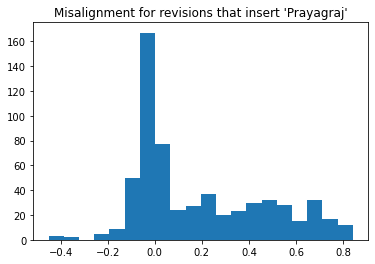

In [104]:
prayagraj_insertions_df = merged_preds_df[merged_preds_df.rev_id.isin(prayagraj_insertions)]
plt.hist(prayagraj_insertions_df.raw_misalignment, bins=20)
plt.title("Misalignment for revisions that insert 'Prayagraj'")
plt.show()

In [106]:
np.sum((prayagraj_insertions_df.revert_prob >= 0.5) == prayagraj_insertions_df.is_reverted) / len(prayagraj_insertions_df)

0.460655737704918

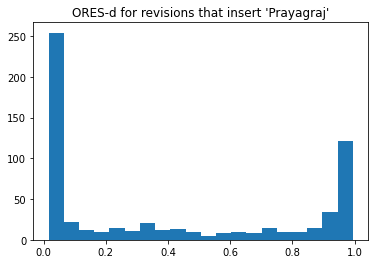

In [107]:
plt.hist(prayagraj_insertions_df.damaging_prob_calibrated, bins=20)
plt.title("ORES-d for revisions that insert 'Prayagraj'")
plt.show()